In [95]:
import os
imdb_dir = r'/Users/cheng/Documents/GitHub/Deep_Learning/0516/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = 'utf8')
            texts.append(f.read()) #讀取評論字串資料存入texts
            f.close()
            if label_type == 'neg':
                labels.append(0)  #負評為0
            else:
                labels.append(1)  #正評為1



In [96]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100  # 100 個文字後切斷評論 (只看評論的前 100 個字)
training_samples = 200  # 以 200 個樣本進行訓練
validation_samples = 10000 # 以 10, 000 個樣本進行驗證
max_words = 10000  # 僅考慮資料集中的前 10, 000 個單詞
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) # 將文字轉成整數 list 的序列資料
word_index = tokenizer.word_index # {‘the’: 1, ‘cat’: 2, ‘sat’: 3,...}文字與索引的詞彙表
print('共使用了 %s 個 token 字詞.' % len(word_index))
27


共使用了 88582 個 token 字詞.


27

In [97]:
data = pad_sequences(sequences, maxlen=maxlen) # 只取每個評論的前 100 個字 (多切少補) 作為資料張量
labels = np.asarray(labels)  # 將標籤 list 轉為 Numpy array (標籤張量)
print('資料張量 shape:', data.shape) # 資料張量shape: (25000, 100)
print('標籤張量 shape:', labels.shape) # 標籤張量shape: (25000,)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
28
# 將資料拆分為訓練集和驗證集, 但
# 首先要將資料打散, 因為所處理的資
# 料是有順序性的樣本資料 (負評在前, 
# 然後才是正評)


資料張量 shape: (25000, 100)
標籤張量 shape: (25000,)


28

In [98]:
glove_dir = r'/Users/cheng/Documents/GitHub/Deep_Learning/0516/封存/glove.6B'
embeddings_index = {} #建立嵌入向量索引字典
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split() #以空格切開每一行字串
    word = values[0] #(字 & 100向量)
    coefs = np.asarray(values[1:], dtype='float32') #將座標值轉為numpy array, (100向量)
    embeddings_index[word] = coefs #儲存文字(鍵)與向量(值)
f.close()
print('共有 %s 個文字嵌入向量' % len(embeddings_index))

共有 400000 個文字嵌入向量


In [99]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim)) #(10000, 100)，只考慮前10000個字，每個字的向量維度為100
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: #如果這個字有向量表示法
            embedding_matrix[i] = embedding_vector # ←將該向量表示法存入矩陣中，嵌入向量索引中找不到的文字將為 0
# 說明：
# 雖然GloVe中內建四萬個字，但還是不包含所有的字詞，所以如果沒有內建的字詞就會轉為0


In [100]:

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
# 參數樣本數(可能的token數量), 嵌入向量維度, 只看評論的前 100 個字
model = Sequential()
# model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(maxlen,)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()
# (10000, 100, 100)
# 說明：
# 若要在embedding層後連接flatten層與dense層，需要設定input_length ，代表輸入序列的最大長度

/Users/cheng/Documents/GitHub/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │       320,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320,065 (5.04 MB)

 Trainable params: 1,320,065 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
model.compile(optimizer='rmsprop', #進行訓練
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.weights.h5') #儲存訓練後的模型


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.5858 - loss: 0.6904 - val_acc: 0.5244 - val_loss: 0.6914
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.9905 - loss: 0.5717 - val_acc: 0.5254 - val_loss: 0.6912
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 1.0000 - loss: 0.4285 - val_acc: 0.5223 - val_loss: 0.6975
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 1.0000 - loss: 0.2631 - val_acc: 0.5249 - val_loss: 0.7063
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.9973 - loss: 0.1435 - val_acc: 0.5280 - val_loss: 0.7069
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 1.0000 - loss: 0.0811 - val_acc: 0.5170 - val_loss: 0.7403
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 1.0000 - loss: 0.0537 - val_acc: 0.5265 - val_loss: 0.7326
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 1.0000 - loss: 0.0303 - val_acc: 0.5302 - val_loss: 0.7445
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 1.0000 - loss: 0.0201 - 

35

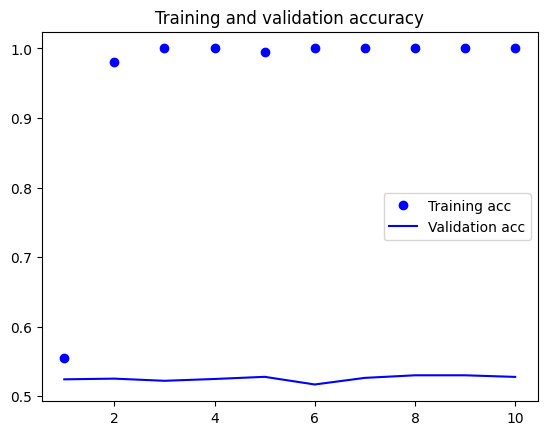

<Figure size 640x480 with 0 Axes>

In [102]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
35


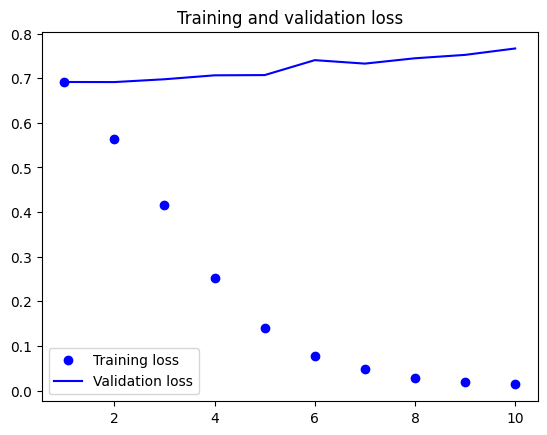

In [103]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
# 說明：
# • 驗證的準確度只有0.5，因為訓練樣本很少，馬上就過度配適
# • 每個人執行的結果可能會有所不同，因為訓練樣本很少，所以隨機選擇後表現結果也會不同


In [104]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
37


/Users/cheng/Documents/GitHub/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.5524 - loss: 0.6903 - val_acc: 0.5199 - val_loss: 0.6918
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.9754 - loss: 0.5925 - val_acc: 0.5238 - val_loss: 0.6972
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.9765 - loss: 0.4675 - val_acc: 0.5218 - val_loss: 0.6977
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.9981 - loss: 0.3013 - val_acc: 0.5205 - val_loss: 0.7064
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 1.0000 - loss: 0.1700 - val_acc: 0.5237 - val_loss: 0.7134
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 1.0000 - loss: 0.1004 - val_acc: 0.5246 - val_loss: 0.7224
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 1.0000 - loss: 0.0608 - val_acc: 0.5245 - val_loss: 0.7350
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 1.0000 - loss: 0.0380 - val_acc: 0.5233 - val_loss: 0.7419
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 1.0000 - loss: 0.0243 - 

37

In [105]:
model.add(Dense(1, activation='sigmoid'))
model.summary()
# 說明：
# • 驗證準確度停滯於50%，由此可知在訓練樣本不足的情況下，使用預先訓練的文字嵌入向量
# 優於從頭開始學習模型，如果我們增加訓練樣本的數量，則結果將會有所不同


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │       320,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,640,134 (10.07 MB)

 Trainable params: 1,320,067 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,320,067 (5.04 MB)

In [106]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='UTF-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels) 


In [107]:
#載入訓練好的模型，並評估測試結果

model2 = Sequential()
model2.load_weights("pre_trained_glove_model.weights.h5")
model.evaluate(x_test, y_test)

# 說明：
# • 使用預訓練的文字嵌入向量建立之模型，測試準確度約55% ，僅使用少量訓練樣本
# (training_samples = 200 # 以 200 個樣本進行訓練)是很難得可以得到這樣的結果!


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - acc: 0.6547 - loss: 0.6796


[0.7743517756462097, 0.5219200253486633]